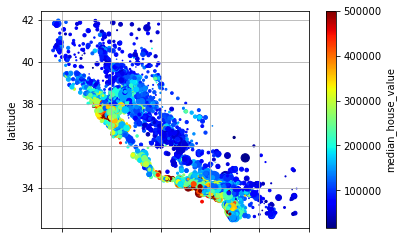

correlation_attr dataframe:
                    longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924213           -0.102937     0.044558   
latitude            -0.924213  1.000000            0.005692    -0.036753   
housing_median_age  -0.102937  0.005692            1.000000    -0.361710   
total_rooms          0.044558 -0.036753           -0.361710     1.000000   
total_bedrooms       0.068210 -0.066391           -0.317978     0.930076   
population           0.104236 -0.115677           -0.301906     0.863967   
households           0.054261 -0.071604           -0.300075     0.916143   
median_income       -0.016542 -0.078137           -0.127043     0.197720   
median_house_value  -0.050859 -0.139584            0.102175     0.137455   

                    total_bedrooms  population  households  median_income  \
longitude                 0.068210    0.104236    0.054261      -0.016542   
latitude                 -0.066391   -0.115677   -0.07160

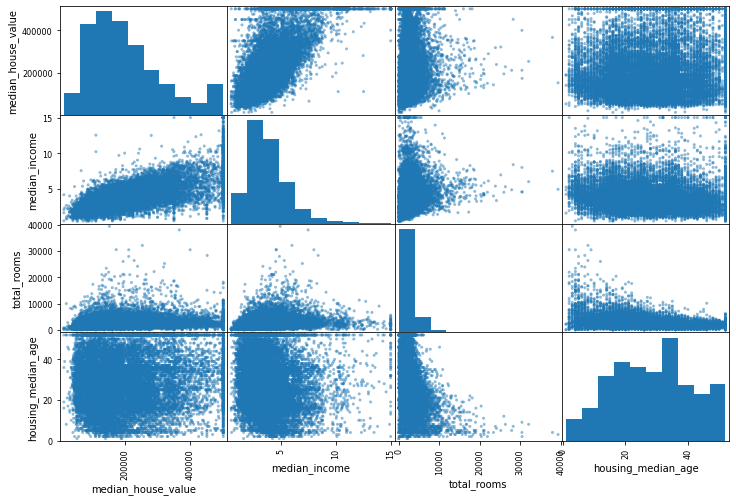

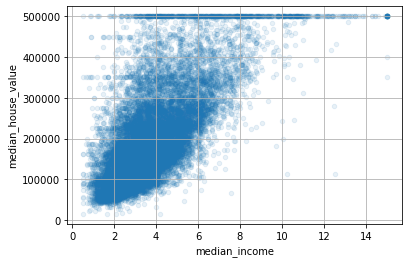

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')
              0         1         2         3         4         5         6  \
0     -1.423037  1.013606  1.861119  0.311912  1.368167  0.137460  1.394812   
1      0.596394 -0.702103  0.907630 -0.308620 -0.435925 -0.693771 -0.373485   
2     -1.203098  1.276119  0.351428 -0.712240 -0.760709 -0.788768 -0.775727   
3      1.231216 -0.884924 -0.919891  0.702262  0.742306  0.383175  0.731375   
4      0.711362 -0.875549  0.589800  0.790125  1.595753  0.444376  1.755263   
...         ...       ...       ...       ...       ...       ...       ...   
16507  0.586397 -0.833359  0.987087 -0.184147  0.140152 -0.445315  0.060101   
16508  0.131525  0.319822 -0.443146  0.139847  0.128298 -0.005950  0.083608   
16509  1.256209 -1.428701 -1.237721  0.586026  0.562134  1.268299  0.679135   


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tarfile
import urllib.request
import numpy as np
import sklearn as sk
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split
def loading_data():
    archive_path=Path('datasets/housing.tgz')#Path object represents  path to archived file containing data
    if not archive_path.is_file():
        Path('datasets').mkdir(parents=True, exist_ok=True)
        #if no file exists in specified path, the new folder datasets is created using Path object
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url,archive_path)
    
    with tarfile.open(archive_path) as housing_zip:
        housing_zip.extractall(path='datasets')
    return(pd.read_csv(Path("datasets/housing/housing.csv")))

housing=loading_data()

housing['income_cat']=pd.cut(housing['median_income'],bins=[0.,1.5,3.0,4.5,6.0,np.inf],labels=[1,2,3,4,5])
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

for set1 in (strat_train_set,strat_test_set):
    set1.drop('income_cat',axis=1,inplace=True)
housing=strat_train_set.copy()

housing.plot(kind='scatter',x='longitude',y='latitude',grid=True,s=housing['population']/100,c='median_house_value'
            ,cmap='jet',colorbar=True,legend=True)
#s means size of markers, c means colors mapped acc to numerical values
#cmap=jet is a colormap that maps numerical values to colors(Low values: Blue,Intermediate values: Green and yellow
#colorbar tells what color mapped to what number
plt.show()#shows distribution of districts, tells higher prices near bay and high populated regions

correlation_attr=housing.corr() #calculates pearsons coeff for every pair of attributes
print('correlation_attr dataframe:')
print(correlation_attr)
print(correlation_attr['median_house_value'].sort_values(ascending=False))


attributes=['median_house_value','median_income','total_rooms','housing_median_age']
#from pd.plotting import scatter_matrix(alter)
pd.plotting.scatter_matrix(housing[attributes],figsize=(12,8))
plt.show()
#this prints histogram i fattributes are same, else scatterplot. another way to judging correlation

housing.plot(kind='scatter',x='median_income',y='median_house_value',grid=True,alpha=0.1)#alpha determine opacity etc
plt.show()

print(housing.columns)
housing_labels=housing[['median_house_value']]
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
target_scalar=StandardScaler()

scaled_labels=target_scalar.fit_transform(housing_labels)
model=LinearRegression()
model.fit(housing[['median_income']],scaled_labels) #trains model on input as median_value and label as scaled_labels
some_new_data=housing[['median_income']].iloc[:5]

scaled_predictions=model.predict(some_new_data)
predictions=target_scalar.inverse_transform(scaled_predictions)
predictions

#TransformedTargetRegressor does the scaling and descaling automatically for labels
from sklearn.compose import TransformedTargetRegressor
model=TransformedTargetRegressor(LinearRegression(),transformer=StandardScaler())
model.fit(housing[['median_income']],housing_labels)
predictions=model.predict(some_new_data)
predictions

#CUSTOM TRANSFORMERS(similar to predefined like StandardScaler but we create them)
from sklearn.preprocessing import FunctionTransformer
log_transf= FunctionTransformer(np.log, inverse_func=np.exp)
log_res=log_transf.transform(housing[['population']])#transforms population to its log

#custom transformation for gaussian similarity, gamma is hyperparameter
from sklearn.metrics.pairwise import rbf_kernel
sim_transf=FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35]],gamma=0.1))
sim_res=sim_transf.transform(housing[['housing_median_age']])

#CUSTOM TRANSFORMATIONS WITH FIT
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted,check_array
from sklearn.cluster import KMeans
class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True): # no *args or **kwargs!
        self.with_mean = with_mean
    def fit(self,x,y=None):#have to pass 2 arguments even if y=None
        x=check_array(x)
        self.mean1=x.mean(axis=0) #finds mean of each column
        self.std1=x.std(axis=0)
        self.no_features=x.shape[1]
        return(self) #important for method chaining
    def transform(self,x):
        assert hasattr(self, 'mean1') and hasattr(self, 'std1')
        #check_is_fitted(self)#throws exception if not fitted
        x=check_array(x)
        assert self.no_features==x.shape[1]
        if self.with_mean:
            x=x-self.mean1
        return(x/self.std1)


housing_num=housing.select_dtypes(include=[np.number])
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy='median')
imputer.fit(housing_num)
housing_num=imputer.transform(housing_num)

ssclone=StandardScalerClone(with_mean=True)
ssclone.fit(housing_num)
ssclone_res=ssclone.transform(housing_num)
print(pd.DataFrame(ssclone_res))

In [2]:
housing_labels=housing['median_house_value']
from sklearn.cluster import KMeans
class ClusterSimilarity(BaseEstimator,TransformerMixin):
    def __init__(self,n_clusters=10,gamma=1,random_state=None):
        self.n_clusters=n_clusters
        self.gamma=gamma
        self.random_state=random_state
    def fit(self,x,y=None,sample_weight=None):
        self.kmeans=KMeans(self.n_clusters,random_state=self.random_state, n_init=10)
        self.kmeans.fit(x,sample_weight=sample_weight)#calculates centroids
        #sample_weight parameter allows you to assign custom weights to individual data points. This means that some data points
        #can be considered more important or influential in the clustering process than others.
        return(self)
    def transform(self,x):
        return(rbf_kernel(x,self.kmeans.cluster_centers_,gamma=self.gamma))
    def get_feature_names_out(self,names=None):
        return([f"Cluster {i} Similarity" for i in range(self.n_clusters)])
cluster_simil=ClusterSimilarity(n_clusters=10,gamma=1,random_state=42)
simil=cluster_simil.fit_transform(housing[['latitude','longitude']],sample_weight=housing_labels)

simil[:3].round(2)
#each row corresponds to one district, and the array values represent the similarity of the district with the 10 cluster centers
#clusters are potentially formed taking into consideration geographic location and how similar these locations are
#on the basis of their median house value

array([[0.08, 0.  , 0.6 , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.14],
       [0.  , 0.99, 0.  , 0.04, 0.  , 0.  , 0.11, 0.  , 0.63, 0.  ],
       [0.44, 0.  , 0.3 , 0.  , 0.  , 0.7 , 0.  , 0.01, 0.  , 0.29]])

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
num_pipeline=Pipeline([('impute',SimpleImputer(strategy='median')),('standardize',StandardScaler())])
#there are 2 tuples inside the list
#the estimators must all be transformers(have fit_transform()), last one can be a predictor

#ALTER don't have to name the transformers here

from sklearn.pipeline import make_pipeline
num_pipeline=make_pipeline(SimpleImputer(strategy='median'),StandardScaler())
housing_num=housing.select_dtypes(include=[np.number])
housing_num_pipeline=num_pipeline.fit_transform(housing_num)
housing_num_pipeline[:2].round(2)#output is an array
pd.DataFrame(housing_num_pipeline,columns=housing_num.columns,index=housing_num.index)
#above pipeline method works only for numerical attributes
#we use ColumnTransform for operating on all types of columns(separate pipeline for numerical and categorical attr)

from sklearn.compose import ColumnTransformer

num_attr= ["longitude", "latitude", "housing_median_age", "total_rooms",
"total_bedrooms", "population", "households", "median_income"]
cat_attr= ["ocean_proximity"]
cat_pipeline=make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown='ignore'))

preprocessing=ColumnTransformer([('num',num_pipeline,num_attr),('cat',cat_pipeline,cat_attr)])
#housing_prepared=preprocessing.fit_transform(housing)

#ALTER

from sklearn.compose import make_column_selector, make_column_transformer
preprocessing=make_column_transformer((num_pipeline,make_column_selector(dtype_include=np.number)),
                                     (cat_pipeline,make_column_selector(dtype_include=object)))
housing_prepared=preprocessing.fit_transform(housing)

In [4]:
def column_ratio(x):
    return(x[:,[0]]/x[:,[1]])
def ratio_name(function_transformer,feature_names_in):
    return "ratio"
def m_pipeline():
    return(make_pipeline(SimpleImputer(strategy='median'),FunctionTransformer(column_ratio)
                        ,StandardScaler()))
log_pipeline=make_pipeline(SimpleImputer(strategy='median'),FunctionTransformer(np.log,inverse_func=np.exp))
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42) 
pipeline_res=ColumnTransformer([('bed_ratio',m_pipeline(),['total_bedrooms','total_rooms']),
                               ('room_ratio',m_pipeline(),['total_rooms','households']),
                               ('people_ratio',m_pipeline(),['population','households']),
                               ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                                "households", "median_income"]),("geo", cluster_simil, ["latitude", "longitude"]),
                               ('cat',cat_pipeline,make_column_selector(dtype_include=object))])
preprocess_res=pipeline_res.fit_transform(housing)
preprocess_res.shape

#TRAINING A MODEL AFTER PREPROCESSING
from sklearn.linear_model import LinearRegression
housing_labels=housing['median_house_value']
lin_reg=make_pipeline(pipeline_res,LinearRegression())
lin_reg.fit(housing,housing_labels)
#above is a trained linear regression model
housing_pred=lin_reg.predict(housing) #this should be training set
print('Predicted values after training:')
print(housing_pred[:5].round(-2))
print('Actual values from dataframe:')
print(housing_labels.iloc[:5].values)
#prediction kinda off my guy, use rmse performance measure to get an idea

from sklearn.metrics import mean_squared_error
rmse_pm=mean_squared_error(housing_labels, housing_pred, squared=False)#pm is performace measure
print(rmse_pm)#average diff in prediction value
print('therefore model is underffitting data')

from sklearn.tree import DecisionTreeRegressor
tree_reg=make_pipeline(pipeline_res,DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing,housing_labels)#trains tree_reg

housing_predictions=tree_reg.predict(housing)
tree_rmse=mean_squared_error(housing_labels,housing_predictions, squared=False)
tree_rmse #we get 0, we are overfitting,this is not a linear algorithm 
#to solve this we split training set again into 2 parts: smaller train set and validation set OR use k fold cross validation

from sklearn.model_selection import cross_val_score
tree_rmses=-cross_val_score(tree_reg,housing,housing_labels,scoring="neg_root_mean_squared_error", cv=10)
print(type(tree_rmses))
pd.Series(tree_rmses).describe()

from sklearn.ensemble import RandomForestRegressor
forest_reg=make_pipeline(pipeline_res,RandomForestRegressor(random_state=42))
forest_reg.fit(housing,housing_labels)
fold_rmses=-cross_val_score(forest_reg,housing,housing_labels,scoring='neg_root_mean_squared_error',cv=10)
print(pd.Series(fold_rmses).describe())


Predicted values after training:
[236000. 373000. 127900. 100600. 323000.]
Actual values from dataframe:
[458300. 483800. 101700.  96100. 361800.]
68812.84577309027
therefore model is underffitting data
<class 'numpy.ndarray'>
count       10.000000
mean     47507.372938
std        938.265188
min      45898.903955
25%      47140.136675
50%      47417.096824
75%      47778.295634
max      49507.838023
dtype: float64


In [5]:
#TWEAKING DA HYPERPARAMETERS

from sklearn.model_selection import GridSearchCV
full_pipeline=Pipeline([('preprocessing',pipeline_res),('randomforest',RandomForestRegressor(random_state=42))])
param_grid=[{'preprocessing__geo__n_clusters':[5,8,10],'randomforest__max_features':[4,6,8]},
           {'preprocessing__geo__n_clusters':[10,15],'randomforest__max_features':[6,8,10]}]
grid_search=GridSearchCV(full_pipeline,param_grid,cv=3,scoring='neg_root_mean_squared_error')
grid_search.fit(housing,housing_labels)
#in param_grid,the key string is split at the double underscore and the respective hyperparameter is evaluated for that location
#all possible combinations of n_clusters and max_features are tried out in a dictionary b4 moving to the next
#cv =3 means model is trained 3 times on each combination of hyperparameter values

print(grid_search.best_params_)

grid_results=pd.DataFrame(grid_search.cv_results_)
grid_results.sort_values(by='mean_test_score',ascending=False,inplace=True)
grid_results.head()

{'preprocessing__geo__n_clusters': 15, 'randomforest__max_features': 6}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_randomforest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,22.894911,0.230850,0.202244,0.007695,15,6,"{'preprocessing__geo__n_clusters': 15, 'random...",-43729.107206,-44065.953374,-44787.709332,-44194.256637,441.592505,1
13,29.443297,0.294400,0.211752,0.008192,15,8,"{'preprocessing__geo__n_clusters': 15, 'random...",-43960.026961,-44668.710365,-45293.413544,-44640.716957,544.712565,2
14,36.073999,0.422847,0.204104,0.004477,15,10,"{'preprocessing__geo__n_clusters': 15, 'random...",-45027.544037,-45135.218448,-45641.387136,-45268.049874,267.624088,3
6,16.271972,0.115016,0.202522,0.007649,10,4,"{'preprocessing__geo__n_clusters': 10, 'random...",-44866.526267,-45448.604357,-46480.888194,-45598.672939,667.548521,4
7,22.936983,0.206719,0.196760,0.002522,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-45235.261675,-45549.169223,-46568.252704,-45784.227867,569.008316,5


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist=[{'preprocessing__geo__n_clusters':randint(low=3,high=20)},{'randomforest__max_features':randint(low=2,high=20)}]
#preprocessing__geo__n_clusters hyperparameter is being assigned a uniform distribution between 3 and 50, and the 
#random_forest__max_features hyperparameter is being assigned a uniform distribution between 2 and 20

random_search=RandomizedSearchCV(full_pipeline,param_dist,n_iter=10,cv=3,random_state=42,scoring='neg_root_mean_squared_error')
random_search.fit(housing,housing_labels)